**Adding Kaggle API, to directly import dataset from kaggle**

In [ ]:
!pip install opendatasets

**Downloading Dataset**

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/danish003/face-images-of-acute-stroke-and-non-acute-stroke")

Dataset URL: https://www.kaggle.com/datasets/danish003/face-images-of-acute-stroke-and-non-acute-stroke


100%|██████████| 36.7M/36.7M [00:02<00:00, 13.7MB/s]


In [102]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import Sequential
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [78]:
def create_dataframe(root_dir):
    data = []
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                data.append({'file_path': file_path, 'class': class_name})
    return pd.DataFrame(data)

In [79]:
root_path = 'face-images-of-acute-stroke-and-non-acute-stroke/main'
dataset = create_dataframe(root_path)

In [80]:
train_df, test_df = train_test_split(dataset, test_size=0.2, stratify=dataset['class'], random_state=42)

In [81]:
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30
)

In [82]:
testing_data_generator = ImageDataGenerator(rescale=1./255)

In [83]:
training_data = training_data_generator.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 3016 validated image filenames belonging to 2 classes.


In [85]:
testing_data = testing_data_generator.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 754 validated image filenames belonging to 2 classes.


In [94]:
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [95]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [97]:
history = model.fit(training_data, epochs=10, validation_data=testing_data)

Epoch 1/10
95/95 [==============================] - 100s 1s/step - loss: 0.5637 - accuracy: 0.7149 - val_loss: 0.4522 - val_accuracy: 0.7520
Epoch 2/10
95/95 [==============================] - 99s 1s/step - loss: 0.4584 - accuracy: 0.7842 - val_loss: 0.3756 - val_accuracy: 0.8408
Epoch 3/10
95/95 [==============================] - 99s 1s/step - loss: 0.3913 - accuracy: 0.8345 - val_loss: 0.3007 - val_accuracy: 0.8687
Epoch 4/10
95/95 [==============================] - 92s 965ms/step - loss: 0.2985 - accuracy: 0.8770 - val_loss: 0.2143 - val_accuracy: 0.9257
Epoch 5/10
95/95 [==============================] - 94s 981ms/step - loss: 0.2604 - accuracy: 0.8982 - val_loss: 0.1934 - val_accuracy: 0.9284
Epoch 6/10
95/95 [==============================] - 92s 969ms/step - loss: 0.2259 - accuracy: 0.9108 - val_loss: 0.1814 - val_accuracy: 0.9377
Epoch 7/10
95/95 [==============================] - 92s 963ms/step - loss: 0.2166 - accuracy: 0.9151 - val_loss: 0.1584 - val_accuracy: 0.9416
Epoch 8

In [98]:
loss, accuracy = model.evaluate(testing_data)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

24/24 [==============================] - 6s 254ms/step - loss: 0.1718 - accuracy: 0.9390
Test Accuracy: 93.90%


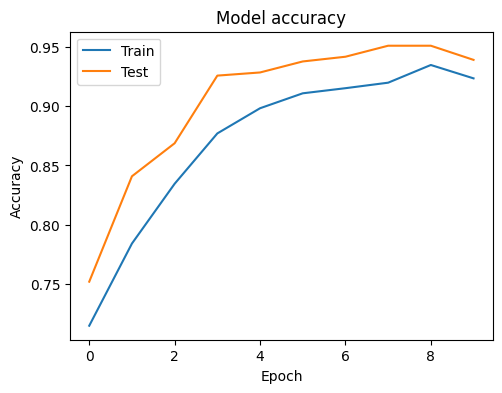

In [99]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

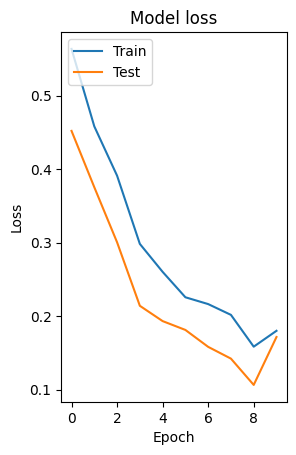

In [100]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## Testing

In [108]:
def predict_image(image_path):
  img = image.load_img(image_path, target_size=(128, 128))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  prediction = model.predict(img_array)
  class_label = 'acute stroke' if prediction[0] > 0.5 else 'non-acute stroke'
  return class_label

In [109]:
image_path = '/content/face-images-of-acute-stroke-and-non-acute-stroke/main/stroke_data/aug_0_1006.jpg'
predicted_class, confidence = predict_image(image_path)
print(f'Predicted Class: {predicted_class}')

1/1 [==============================] - 0s 30ms/step
Predicted Class: acute stroke
